This notebook provides аn example of a simple trend-following strategy on one instrument.
The strategy is tested on synthetic continuous NQ futures on the CME.

Loading necessary libraries:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
from tqdm.notebook import tqdm

Function for reading data from a file:

In [ ]:
def read_data(ticker):
    """
    Read logarithmic returns from file

    :ticker: ticker of continious futures
    """
    # You need to insert the path to the data file
    data = pd.read_csv(ticker+'.csv', index_col = 'date')
    #All datasets for this course are available at this link:
    #https://drive.google.com/drive/folders/1mhbVjuwNZGX9nmZuCxJStBmraF3HIzio?usp=sharing

    # Parse timestamps
    data.index = pd.to_datetime(data.index, format = "%Y-%m-%d %H:%M:%S")

    return data

Functions for calculating some standard statistics:

In [ ]:
days_in_year = 365.25
# Most packages use a constant of 252 trading days per year, but here we use calendar days by adding zero returns on weekends.
# This approach is used to allow for backtesting strategies that trade a portfolio of instruments on different exchanges and in different time zones.
# Trading hours on one exchange may fall on weekends on another.

def Return(rets):
    """
    Annual return estimate

    :rets: daily returns of the strategy
    """
    return np.mean(rets)*days_in_year


def Volatility(rets):
    """
    Estimation of annual volatility

    :rets: daily returns of the strategy
    """
    return np.std(rets)*np.sqrt(days_in_year)


def SharpeRatio(rets):
    """
    Estimating the annual Sharpe ratio

    :rets: daily returns of the strategy
    """
    volatility = Volatility(rets)
    if (volatility>0):
        return Return(rets)/volatility
    else:
        return float('NaN')

def statistics_calc(rets, bh, name = '_', plot = False):
    """
    Draws a graph of portfolio equity and calculates annual Sharpe ratios, profitability and volatility

    :rets: daily returns of the strategy
    """
    sharpe = SharpeRatio(rets)
    ret = Return(rets)
    vol = Volatility(rets)
    if plot:
        plt.plot(rets.cumsum(), label = 'strategy')
        plt.plot(bh.cumsum(), label = 'buy & hold')
        plt.xlabel('t')
        plt.legend()
        print('Sharpe ratio = %0.2f'%sharpe)
        print('Annual Return = %0.2f'%ret)
        print('Annual Std = %0.2f'%vol)
    return  pd.DataFrame([[sharpe, ret, vol]], columns = ['Sharpe ratio', 'Annual return', 'Volatility'], index = [name])

Reading data:

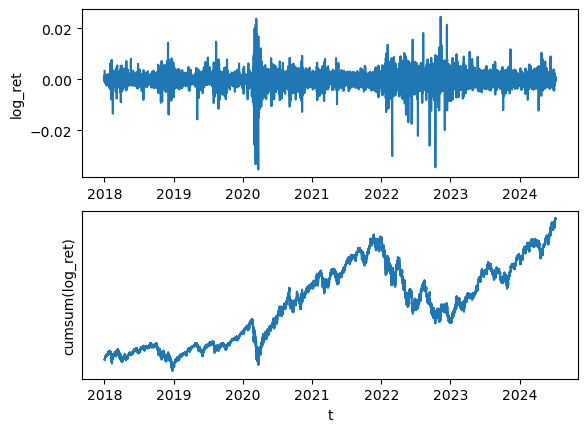

In [ ]:
data = read_data('NQ')

# Let's draw graphs
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(data)
ax1.set_ylabel('log_ret')

ax2.plot(data.cumsum())
ax2.set_yticks([])
ax2.set_ylabel('cumsum(log_ret)')
_ = ax2.set_xlabel('t')

Prepare train and test samples:

In [ ]:
in_sample_start = '2018-01-01'
in_sample_end = '2022-01-01'

train = data[in_sample_start:in_sample_end]
test = data[in_sample_end:]
train_test = data[in_sample_start:]

Function for strategy logic and backtest calculation:

In [ ]:
def strategy_backtest(data, params, plot = False, in_sample_end = '', slippage = 0.00001):
    """
    Strategy backtest calculation
    Example call:
    strategy_bactest(test, [period, scale])

    :data: dataframe with log returns
    :params: list of strategy parameters
    :plot: if True than equity curve is plotted
    :in_sample_end: string in format "%Y-%m-%d" with timestamp of in_sample_end. Only used on charts
    :slippage: slippage per trade

    :return: statistics and equity curve
    """

    # Strategy parameters that we will optimize
    period = params[0]
    scale = params[1]

    # Calculation of target position:

    features = pd.DataFrame(index = data.index)

    # We calculate the exponential moving average of increments:
    features['signal'] = data['log_ret'].ewm(period).mean()

    # Estimating signal volatility using exponential moving average
    features['absSignal'] = np.abs(features['signal']).shift(1)
    features['signal_vol'] = features['absSignal'].ewm(200).mean()+0.000000001

    # Estimating asset volatility using double exponential moving average:
    features['absRet'] = np.abs(data['log_ret'])
    features['EmaAbsRet'] = features['absRet'].ewm(20).mean().shift(1)*np.sqrt(20)
    features['vol'] = features['EmaAbsRet'].ewm(200).mean()*np.sqrt(200)+0.000000001

    # Calc target position:
    features['position'] = ((features['signal']/features['signal_vol']/features['vol']*scale).shift(1)).fillna(0).astype(int)

    # We remove looking into the future
    # (we cannot execute the order at the same price at which the signal was calculated. We need to take the price of the next bar)
    features['position'] = features['position'].shift(1)

    # We trade whole lots
    features['position'] = features['position'].fillna(0).astype(int)

    # Maximum position limit
    pos_limit = 1
    features.loc[features.index[features['position']>pos_limit], 'position'] = pos_limit
    features.loc[features.index[features['position']<-pos_limit], 'position'] = -pos_limit

    # We calculate the equity curve and convert it to a daily timeframe to calculate basic statistics
    eq = (data['log_ret']*features['position']-slippage*features['position'].diff().abs()
         ).fillna(0).resample('1D').agg('sum')
    bh = data['log_ret'].fillna(0).resample('1D').agg('sum')

    # We calculate statistics and save the result
    stats = statistics_calc(eq, bh, name = "{0}_{1}".format(period, scale), plot = plot)
    stats['period'] = period
    stats['scale'] = scale

    # Draw a graph of position changes, if necessary
    if plot:
        if in_sample_end  != '':
            plt.axvline(x = datetime.datetime.strptime(in_sample_end, "%Y-%m-%d").date(), color = 'red')
        plt.figure()
        position_to_plot = features['position'][-10000:]
        plt.plot(np.arange(len(position_to_plot)), position_to_plot)
        plt.title('position')
        plt.xlabel('t')

    return stats, eq

Grid for strategy parameters:

In [ ]:
periods = (np.logspace(1.0, 4.0, num = 20)).astype(int)
scales = np.logspace(-2.0, 0.0, num = 20).round(4)

print('Periods: ',periods)
print('Scales: ', scales)

Periods:  [   10    14    20    29    42    61    88   127   183   263   379   545
   784  1128  1623  2335  3359  4832  6951 10000]
Scales:  [0.01   0.0127 0.0162 0.0207 0.0264 0.0336 0.0428 0.0546 0.0695 0.0886
 0.1129 0.1438 0.1833 0.2336 0.2976 0.3793 0.4833 0.6158 0.7848 1.    ]


Searching through the grid of parameters (can take quite a long time):

In [ ]:
stats = pd.DataFrame()

for period in tqdm(periods):
    for scale in scales:
        stats_current, _ = strategy_backtest(train, [period, scale])
        if stats.shape[0] == 0:
            stats = stats_current
        else:
            stats = pd.concat([stats, stats_current])

  0%|          | 0/20 [00:00<?, ?it/s]

Optimization results on heatmap:

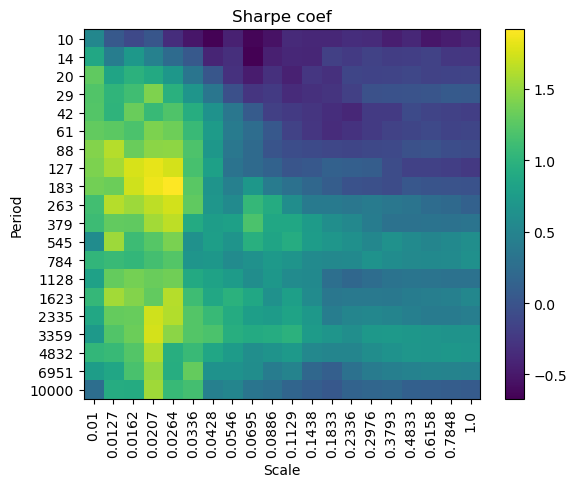

In [ ]:
stats_pivot = stats.pivot(index = 'period', columns = 'scale', values = 'Sharpe ratio')

plt.imshow(stats_pivot, aspect = 'auto', interpolation = 'none')
plt.xticks(np.arange(len(scales)), scales, rotation = 90)
plt.yticks(np.arange(len(periods)), periods)
plt.title('Sharpe coef')
plt.xlabel('Scale')
plt.ylabel('Period')

_ = plt.colorbar()

Best set of parameters:

In [ ]:
temp = stats_pivot.values
amax = temp.argmax()
row, col = (amax//temp.shape[1], amax%temp.shape[1])
print('Sharpe ratio = ', stats_pivot.iloc[row, col])
print('Period = ', stats_pivot.index[row], 'Scale = ', stats_pivot.columns[col])

best_is_stats = stats.sort_values('Sharpe ratio', ascending = False).iloc[0]

Sharpe ratio =  1.9170259174787587
Period =  183 Scale =  0.0264


We calculate equity on data that includes a test period:

Sharpe ratio = 1.69
Annual Return = 0.19
Annual Std = 0.12


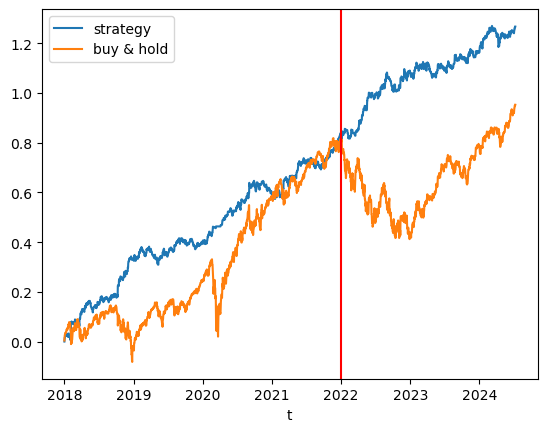

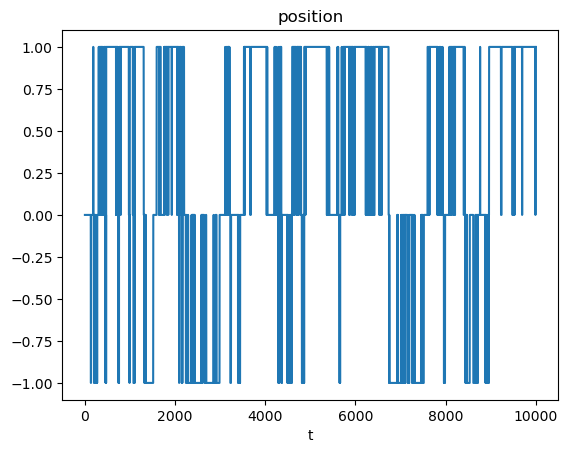

In [ ]:
_, eq = strategy_backtest(train_test, [best_is_stats['period'].astype(int), best_is_stats['scale']], True, in_sample_end)

Calculate statistics on test data:

Sharpe ratio = 1.38
Annual Return = 0.17
Annual Std = 0.12


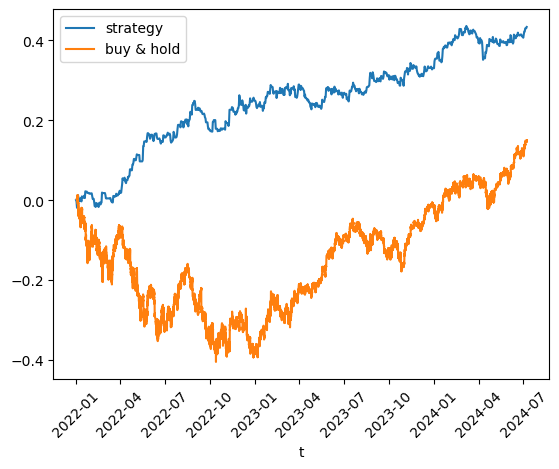

In [ ]:
statistics_calc(eq[in_sample_end:], test, name = "{0}_{1}".format(period, scale), plot = True)
_=plt.xticks(rotation = 45)

Creating a report using pyfolio

Start date,2018-01-01
End date,2024-07-08
Total months,113
,Backtest
Annual return,13.837%
Cumulative returns,240.253%
Annual volatility,9.561%
Sharpe ratio,1.40
Calmar ratio,1.68
Stability,0.99
Max drawdown,-8.221%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.22,2024-03-07,2024-04-10,NaT,NaN
1,7.45,2022-08-30,2022-10-05,2022-11-30,67
2,7.18,2020-09-28,2021-01-17,2021-03-09,117
3,7.05,2019-03-24,2019-05-10,2019-08-05,96
4,6.29,2023-03-09,2023-04-26,2023-08-23,120


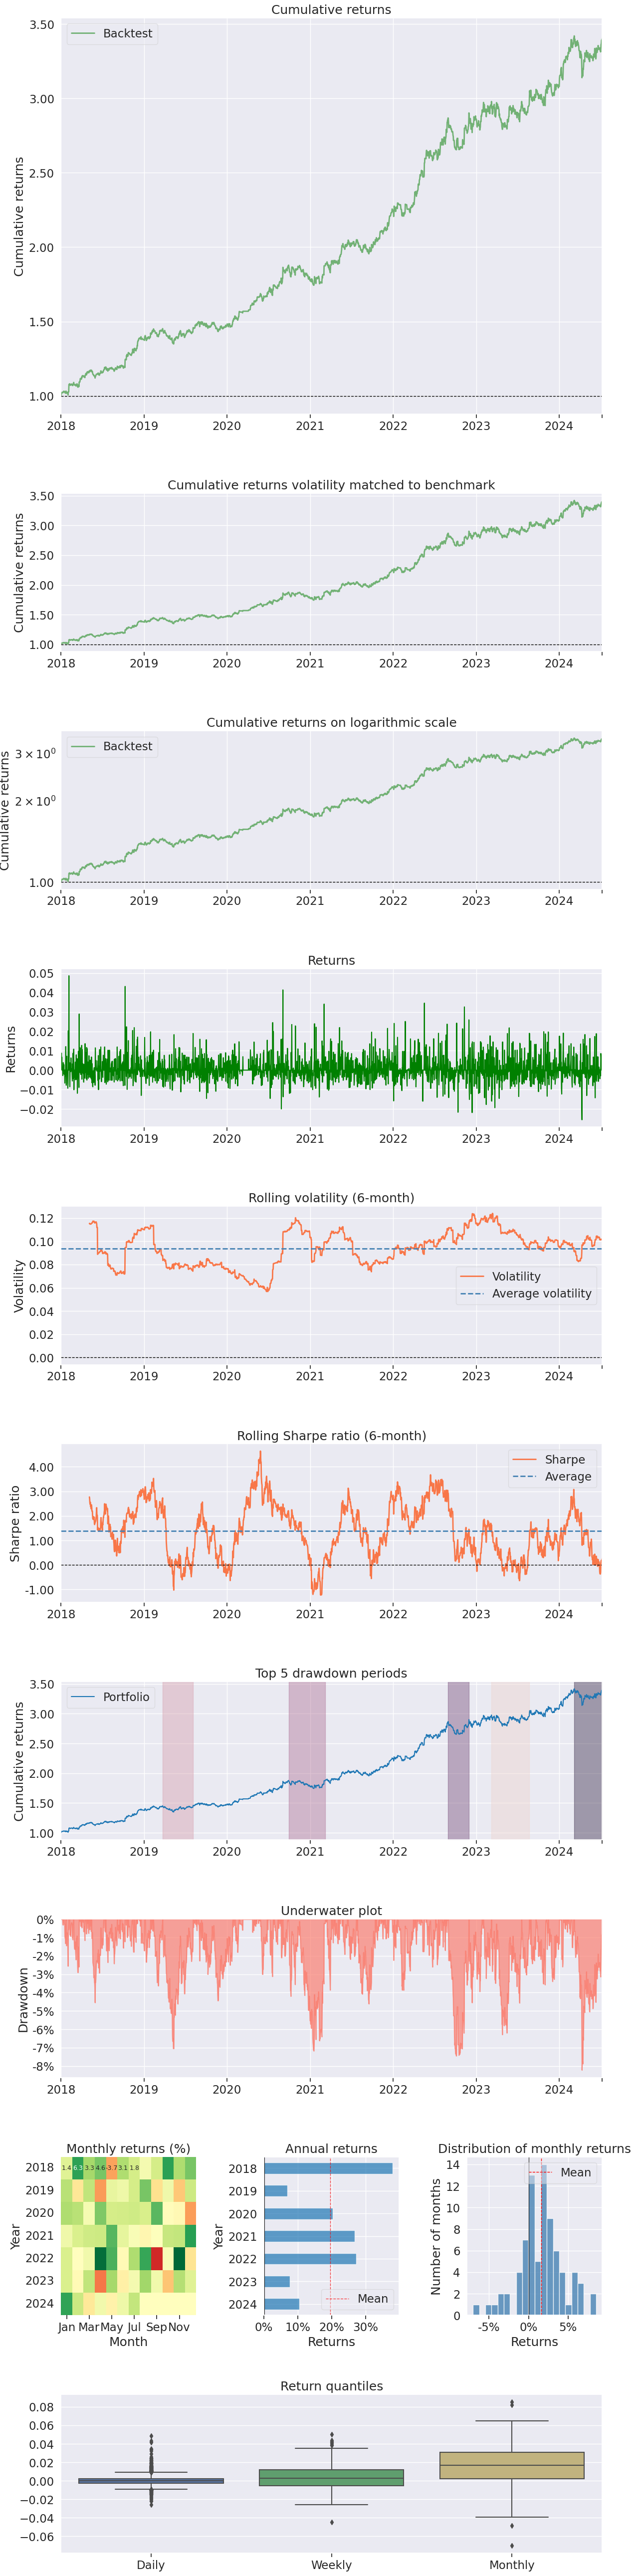

In [ ]:
# Disabling compatibility errors
import warnings
warnings.filterwarnings('ignore')
import pyfolio as pf

pd.Series.iteritems = pd.Series.items
f = pf.create_returns_tear_sheet(eq, return_fig = True)

Additional exercises and research topics:

1.  Optimize all strategy parameters. Study the sensitivity of strategy to small changes in parameters.
2.  Test the strategy on other timeframes and instruments.
3.  Try using other parametric families of functions (trend-following indicators) to form the target position.
4.  Implement a walk-forward optimization scheme.
5.  Construct a portfolio of strategies.

